In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
import os
import pandas as pd

# Dataset path
dataset_path = "/kaggle/input/fruit-quality-classification"
data = []

for quality in os.listdir(dataset_path):  # Bad Quality_Fruits, Good Quality_Fruits, Mixed Qualit_Fruits
    quality_path = os.path.join(dataset_path, quality)
    if os.path.isdir(quality_path):
        for fruit_folder in os.listdir(quality_path):  # Apple_Bad, Banana_Good, etc.
            fruit_path = os.path.join(quality_path, fruit_folder)
            if os.path.isdir(fruit_path):
                # Extract fruit name and quality from the folder name
                fruit = fruit_folder.rsplit("_", 1)[0]
                for img in os.listdir(fruit_path):
                    img_path = os.path.join(fruit_path, img)
                    if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append([img_path, fruit, quality])

# DataFrame
df = pd.DataFrame(data, columns=["image_path", "fruit", "quality"])
df

,image_path,fruit,quality
0,/kaggle/input/fruit-quality-classification/Goo...,Apple,Good Quality_Fruits
1,/kaggle/input/fruit-quality-classification/Goo...,Apple,Good Quality_Fruits
2,/kaggle/input/fruit-quality-classification/Goo...,Apple,Good Quality_Fruits
3,/kaggle/input/fruit-quality-classification/Goo...,Apple,Good Quality_Fruits
4,/kaggle/input/fruit-quality-classification/Goo...,Apple,Good Quality_Fruits
...,...,...,...
19521,/kaggle/input/fruit-quality-classification/Bad...,Apple,Bad Quality_Fruits
19522,/kaggle/input/fruit-quality-classification/Bad...,Apple,Bad Quality_Fruits
19523,/kaggle/input/fruit-quality-classification/Bad...,Apple,Bad Quality_Fruits
19524,/kaggle/input/fruit-quality-classification/Bad...,Apple,Bad Quality_Fruits


In [ ]:
# Total number of images
total_images = len(df)
print(f"Total number of images: {total_images}")

# Number of images per fruit
images_per_fruit = df['fruit'].value_counts()
print("\nNumber of images per fruit:")
print(images_per_fruit)

# Number of images per quality
images_per_quality = df['quality'].value_counts()
print("\nNumber of images per quality:")
print(images_per_quality)

Total number of images: 19526

Number of images per fruit:
fruit
Pomegranate    7252
Orange         2500
Banana         2485
Guava          2429
Apple          2403
Lime           2179
Lemon           278
Name: count, dtype: int64

Number of images per quality:
quality
Good Quality_Fruits    11664
Bad Quality_Fruits      6788
Mixed Qualit_Fruits     1074
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np

# function to load fruit data
def load_fruit_data(fruit):
    # filtering dataset for selected fruit
    df_fruit = df[df['fruit'] == fruit]
    images, labels = [], []

    for _, row in df_fruit.iterrows():
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # converting BGR to RGB
        img = cv2.resize(img, (256, 256))  # resizing to fixed size
        images.append(img)
        labels.append(row['quality'])

    images = np.array(images) / 255.0  # normalizing pixel values
    return images, labels


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np

# function to analyze fruit data
def analyze_fruit_data(fruit, images, labels):
    # encoding labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    unique_labels = label_encoder.classes_

    # printing class distribution
    print(f"\nClass Distribution for {fruit}:")
    class_counts = pd.Series(encoded_labels).value_counts()
    for i, count in class_counts.items():
        print(f"{unique_labels[i]}: {count}")

    # plotting class distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels)
    plt.title(f"{fruit} - Class Distribution")
    plt.show()

    # plotting sample images from each class
    num_classes = len(unique_labels)
    num_samples = 5

    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 3 * num_classes))
    fig.suptitle(f"{fruit} - Sample Images by Class", fontsize=16)

    for i, label in enumerate(unique_labels):
        # getting indices for the current class
        indices = np.where(np.array(labels) == label)[0][:num_samples]
        for j, idx in enumerate(indices):
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(images[idx])
            ax.set_title(label)
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# function to prepare data
def prepare_data(images, labels):
    # splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # encoding labels
    unique_labels = np.unique(labels)
    y_train_enc = to_categorical([np.where(unique_labels == y)[0][0] for y in y_train])
    y_test_enc = to_categorical([np.where(unique_labels == y)[0][0] for y in y_test])

    # augmenting training data
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow(X_train, y_train_enc, batch_size=32)


    # calculating class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    class_weights_dict = dict(enumerate(class_weights))

    return train_generator, X_test, y_train_enc, y_test_enc, class_weights_dict


# Hyperparameter Tuning

In [ ]:
import keras_tuner as kt
from tensorflow.keras import layers, models

# function to hypertune the model
def hypertune_model(train_generator, X_test, y_train_enc, y_test_enc, class_weights, input_shape, num_classes):
    def build_model(hp):
        model = models.Sequential()
        model.add(layers.Conv2D(
            int(hp.Int('conv1_filters', min_value=16, max_value=64, step=16)),
            (3, 3),
            activation='relu',
            input_shape=input_shape
        ))
        model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Conv2D(
            int(hp.Int('conv2_filters', min_value=32, max_value=128, step=32)),
            (3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Flatten())
        model.add(layers.Dense(
            int(hp.Int('dense_units', min_value=64, max_value=256, step=32)),
            activation='relu'
        ))
        model.add(layers.Dropout(float(hp.Float('dropout', 0.1, 0.5, step=0.2))))

        model.add(layers.Dense(num_classes, activation='softmax'))

        model.compile(
            optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='hypertuning',
        project_name='fruit_classification'
    )

    # Fixing class weight data type issue
    class_weights = {int(k): float(v) for k, v in class_weights.items()}

    tuner.search(
        train_generator,
        epochs=10,
        validation_data=(X_test, y_test_enc),
        class_weight=class_weights
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"\nBest Hyperparameters: {best_hps.values}")

    # building final model with best hyperparameters
    model = build_model(best_hps)

    return model


Loaded 2485 images for Banana

Class Distribution for Banana:
Good Quality_Fruits: 1113
Bad Quality_Fruits: 1087
Mixed Qualit_Fruits: 285


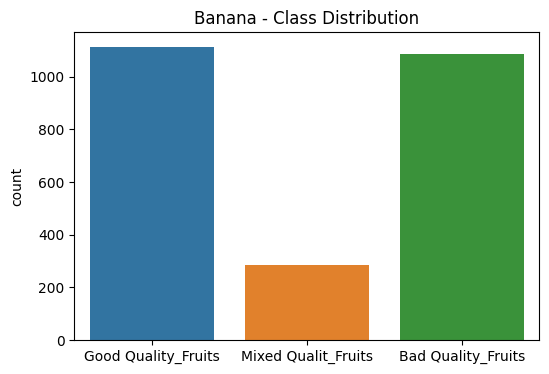

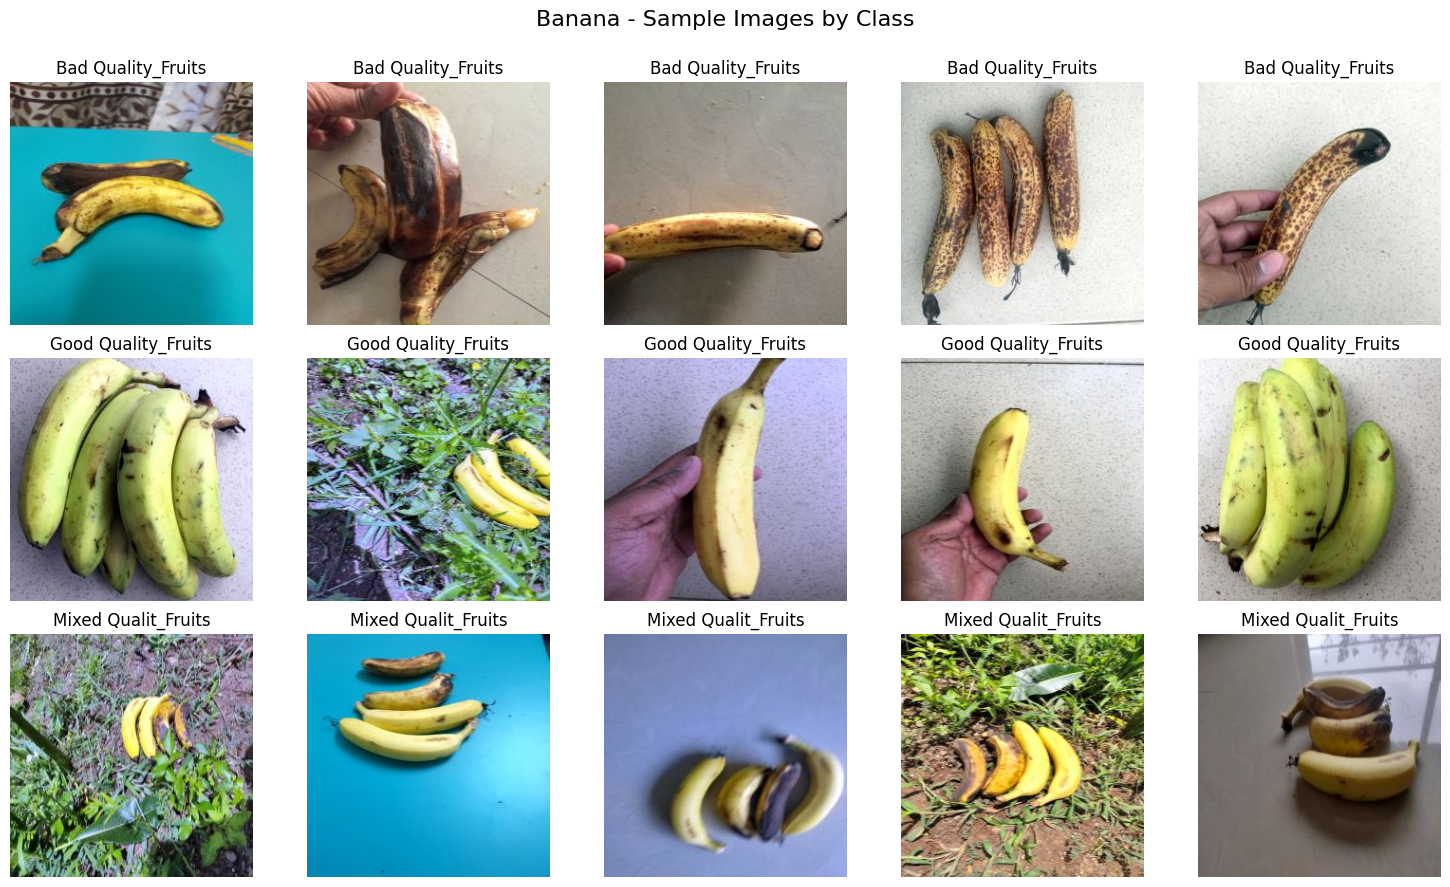

In [ ]:
fruit = "Banana"

# loading data
images, labels = load_fruit_data(fruit)
print(f"Loaded {len(images)} images for {fruit}")

# analyzing data
analyze_fruit_data(fruit, images, labels)

# preparing data
train_generator, X_test, y_train_enc, y_test_enc, class_weights = prepare_data(images, labels)



In [ ]:
# # creating and hypertuning model
# input_shape = (256, 256, 3)
# num_classes = len(np.unique(labels))
# model = hypertune_model(train_generator, X_test, y_train_enc, y_test_enc, class_weights, input_shape, num_classes)